# Assignment 2: Classification
# Using Machine Learning Tools

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are: 

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise data and determine the best pre-processing;
- to create the necessary datasets for training and testing purposes;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code runs correctly on the original data file.

Some of the parts of this assignment build on the workflow from the first assignment and that part of the course, and so less detailed instructions are provided for this, as you should be able to implement this workflow now without low-level guidance. A substantial portion of the marks for this assignment are associated with making the right choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and certain restrictions on sklearn functions will be made clear in the instruction text. You are expected to search and carefully read the documentation for functions that you use, to ensure you are using them correctly.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled 300 samples for you, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail, as appropriate to the marks given.

## 1. Investigate Dataset (10% = 3 marks)

In [1]:
# This code imports some libraries that you will need. 
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

### 1.1 Load the dataset [0.5 marks]
Do this from the csv file, `assignment2.csv`, as done in assignment 1 and workshops 2 and 3. Extract the feature names and label names for use later on.  Note that we will be treating the _malignant_ case as our _positive_ case, as this is the standard convention in medicine.

**Print out some information (in text) about the data, to verify that the loading has worked and to get a feeling for what is present in the dataset and the range of the values.**

**Also, graphically show the proportions of the labels in the whole dataset.**

In [2]:
# Your code here
breast_cancer = pd.read_csv("assignment2.csv")

# Extract feature names
feature_names = breast_cancer.columns[1:]
# Extract label names
label_names = breast_cancer.columns[0]

breast_cancer.head()


,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,malignant,15.494654,15.902542,103.008265,776.437239,0.104239,0.168660,0.170572,0.085668,0.205053,...,19.522957,22.427276,135.128520,1286.903131,0.142725,0.407483,0.445992,0.171662,0.353211,0.097731
1,malignant,16.229871,18.785613,105.176755,874.712003,0.091843,0.092548,0.081681,0.053670,0.180435,...,19.140235,24.905156,123.886045,1234.499997,0.129135,0.223918,0.248846,0.136735,0.284427,0.085758
2,malignant,16.345671,20.114076,107.083804,872.563251,0.099924,0.123799,0.128788,0.078310,0.189756,...,19.144816,25.601433,125.113036,1202.749973,0.135017,0.314402,0.332505,0.161497,0.313038,0.084340
3,malignant,13.001009,19.876997,85.889775,541.281012,0.113423,0.173069,0.146214,0.069574,0.212078,...,15.565911,26.145119,102.958265,737.655082,0.161390,0.485912,0.430007,0.167254,0.432297,0.117705
4,malignant,16.416060,17.397533,107.857386,891.516818,0.097321,0.111530,0.125971,0.068575,0.179562,...,18.620376,22.306233,124.002529,1139.490971,0.133950,0.230996,0.316620,0.131715,0.269591,0.080497


In [3]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    object 
 1   mean radius              300 non-null    float64
 2   mean texture             300 non-null    float64
 3   mean perimeter           300 non-null    float64
 4   mean area                300 non-null    float64
 5   mean smoothness          300 non-null    float64
 6   mean compactness         300 non-null    float64
 7   mean concavity           300 non-null    float64
 8   mean concave points      300 non-null    float64
 9   mean symmetry            300 non-null    float64
 10  mean fractal dimension   300 non-null    float64
 11  radius error             300 non-null    float64
 12  texture error            300 non-null    float64
 13  perimeter error          300 non-null    float64
 14  area error               3

In [4]:
breast_cancer.describe().T

,count,mean,std,min,25%,50%,75%,max
mean radius,300.0,14.231808,1.297393,11.560025,13.356676,13.976933,15.103078,19.090091
mean texture,300.0,19.312619,1.572224,15.349270,18.194791,19.220652,20.245660,26.836291
mean perimeter,300.0,92.727687,8.949937,74.690886,86.659535,90.896982,99.093762,126.168030
mean area,300.0,664.367372,129.515717,477.371592,580.383274,628.004851,737.444716,1300.788708
mean smoothness,300.0,0.096937,0.005067,0.084651,0.093305,0.096722,0.099995,0.114500
mean compactness,300.0,0.106615,0.020819,0.075184,0.091105,0.102401,0.117334,0.192880
mean concavity,300.0,0.092591,0.030312,0.050771,0.069071,0.084829,0.107994,0.212704
mean concave points,300.0,0.050820,0.014350,0.028701,0.039507,0.046744,0.060606,0.105212
mean symmetry,300.0,0.182546,0.010754,0.157059,0.175353,0.181685,0.187789,0.226448
mean fractal dimension,300.0,0.062841,0.002736,0.057830,0.060950,0.062477,0.064149,0.076091


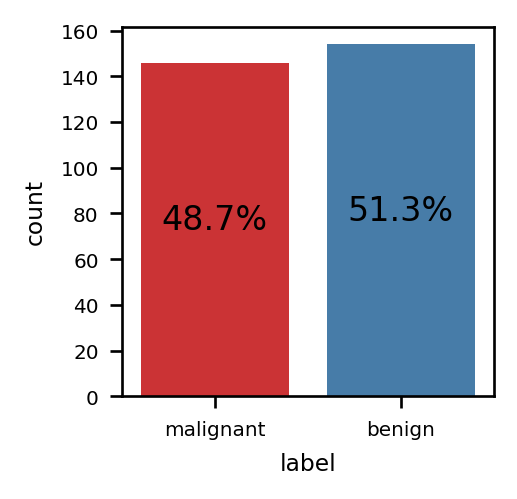

In [5]:
plt.figure(figsize=(2, 2))
total = float(len(breast_cancer))
ax = sns.countplot(x="label", data=breast_cancer,palette='Set1')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()/2
    ax.annotate(percentage, (x, y),ha='center')
plt.show()



### 1.2 Visualise the dataset [1.5 marks]

As this data is well curated by the client already, you do not need to worry about outliers, missing values or imputation in this case, but be aware that this is the exception, not the rule.

To familiarise yourself with the nature and information contained in the data, display histograms for the data according to the following instructions:
 - **display histograms** for each feature in the _mean_ group, but on _each_ histogram **have the two classes displayed together in one plot** (see example plot below and a code fragment to help you) - and note that your plot does not need to look exactly the example here;
 - **repeat this** for the _standard error_ and _worst_ groups;
 - make sure that in all cases you clearly label the plots and the classes in histograms.

<center><img src="Example_Hist_Plot.png" width="300" alt="Example plot of histogram"></center>

In [6]:
# Code fragment to help with plotting histograms combining matplotlib and seaborn (and pandas)
# fig, axes = plt.subplots(Nrows, Ncols, figsize=(?, ?))

# sns.histplot(data=df, x=??, hue="??", bins=??, kde=True, ax=axes[row,col], edgecolor=None)

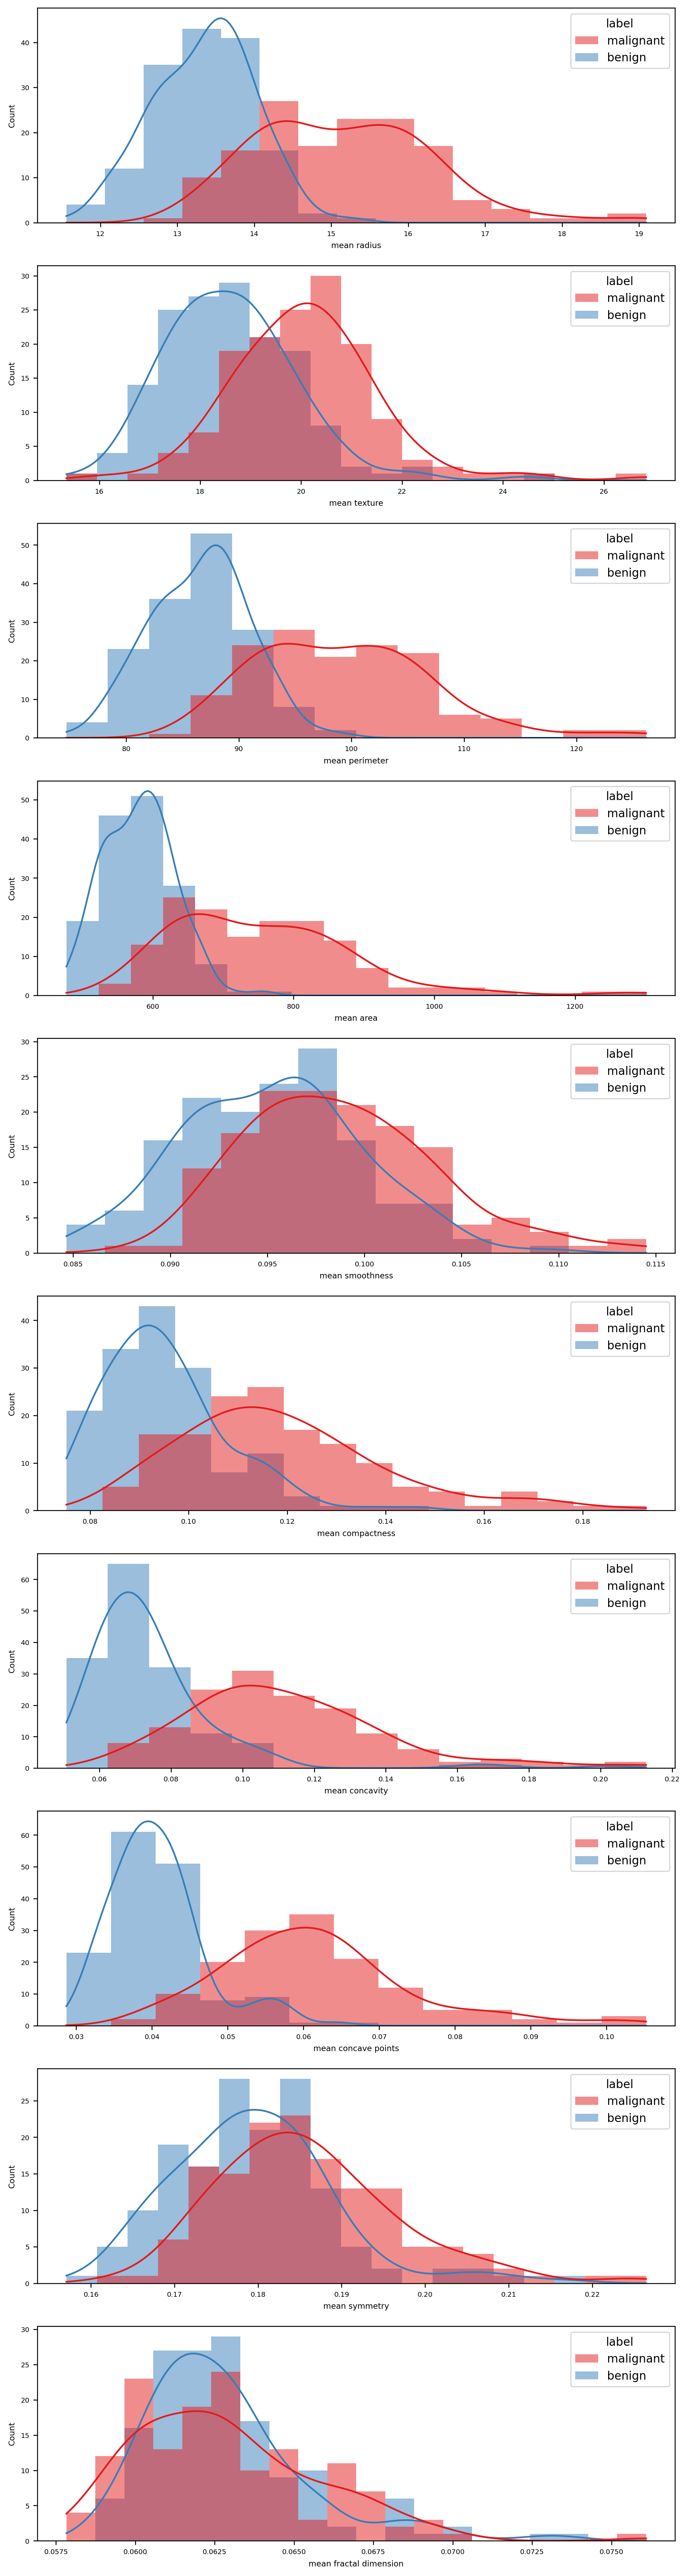

In [7]:
# Your code here
# Display histograms for each feature in the mean group
fig, axes = plt.subplots(10, 1, figsize=(10,40))
for i, col in zip(range(11), list(breast_cancer.columns[1:11])):
    sns.histplot(ax=axes[i], x=col, data=breast_cancer, kde=True, palette='Set1', hue='label',edgecolor=None)
    

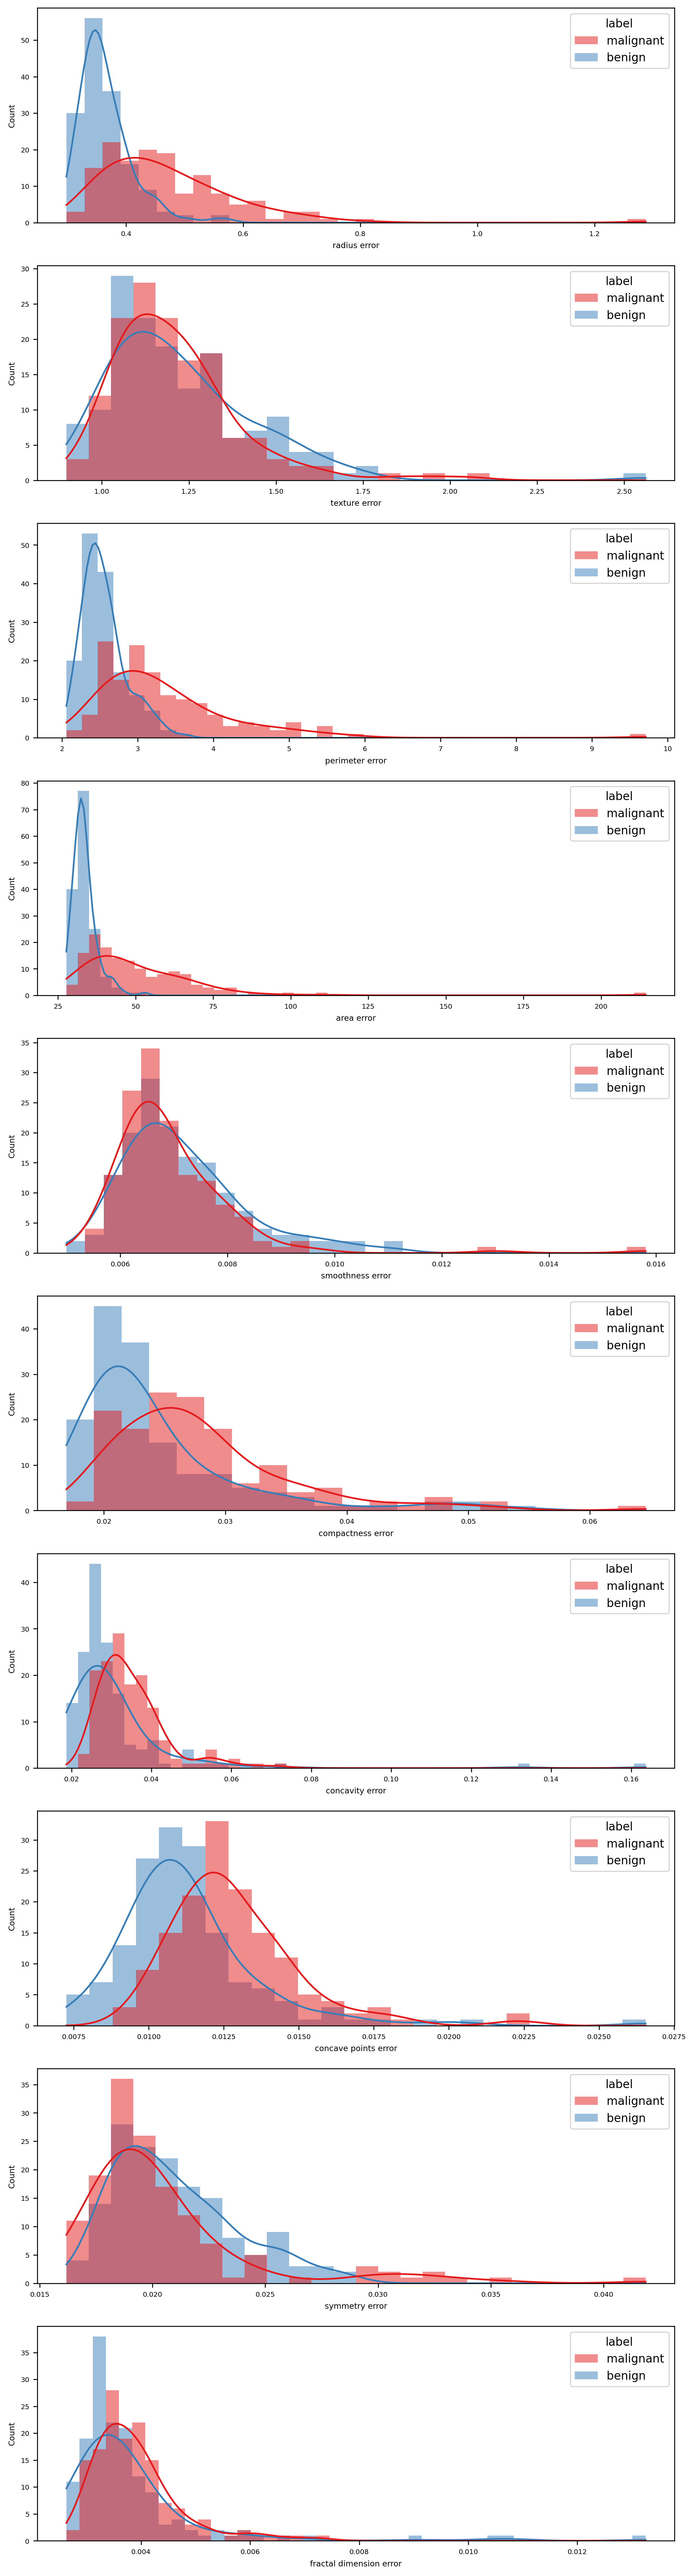

In [8]:
# Display histograms for each feature in the standard error group
fig, axes = plt.subplots(10, 1, figsize=(10,40))
for i, col in zip(range(10), list(breast_cancer.columns[11:21])):
    sns.histplot(ax=axes[i], x=col, data=breast_cancer, kde=True, palette='Set1', hue='label',edgecolor=None)

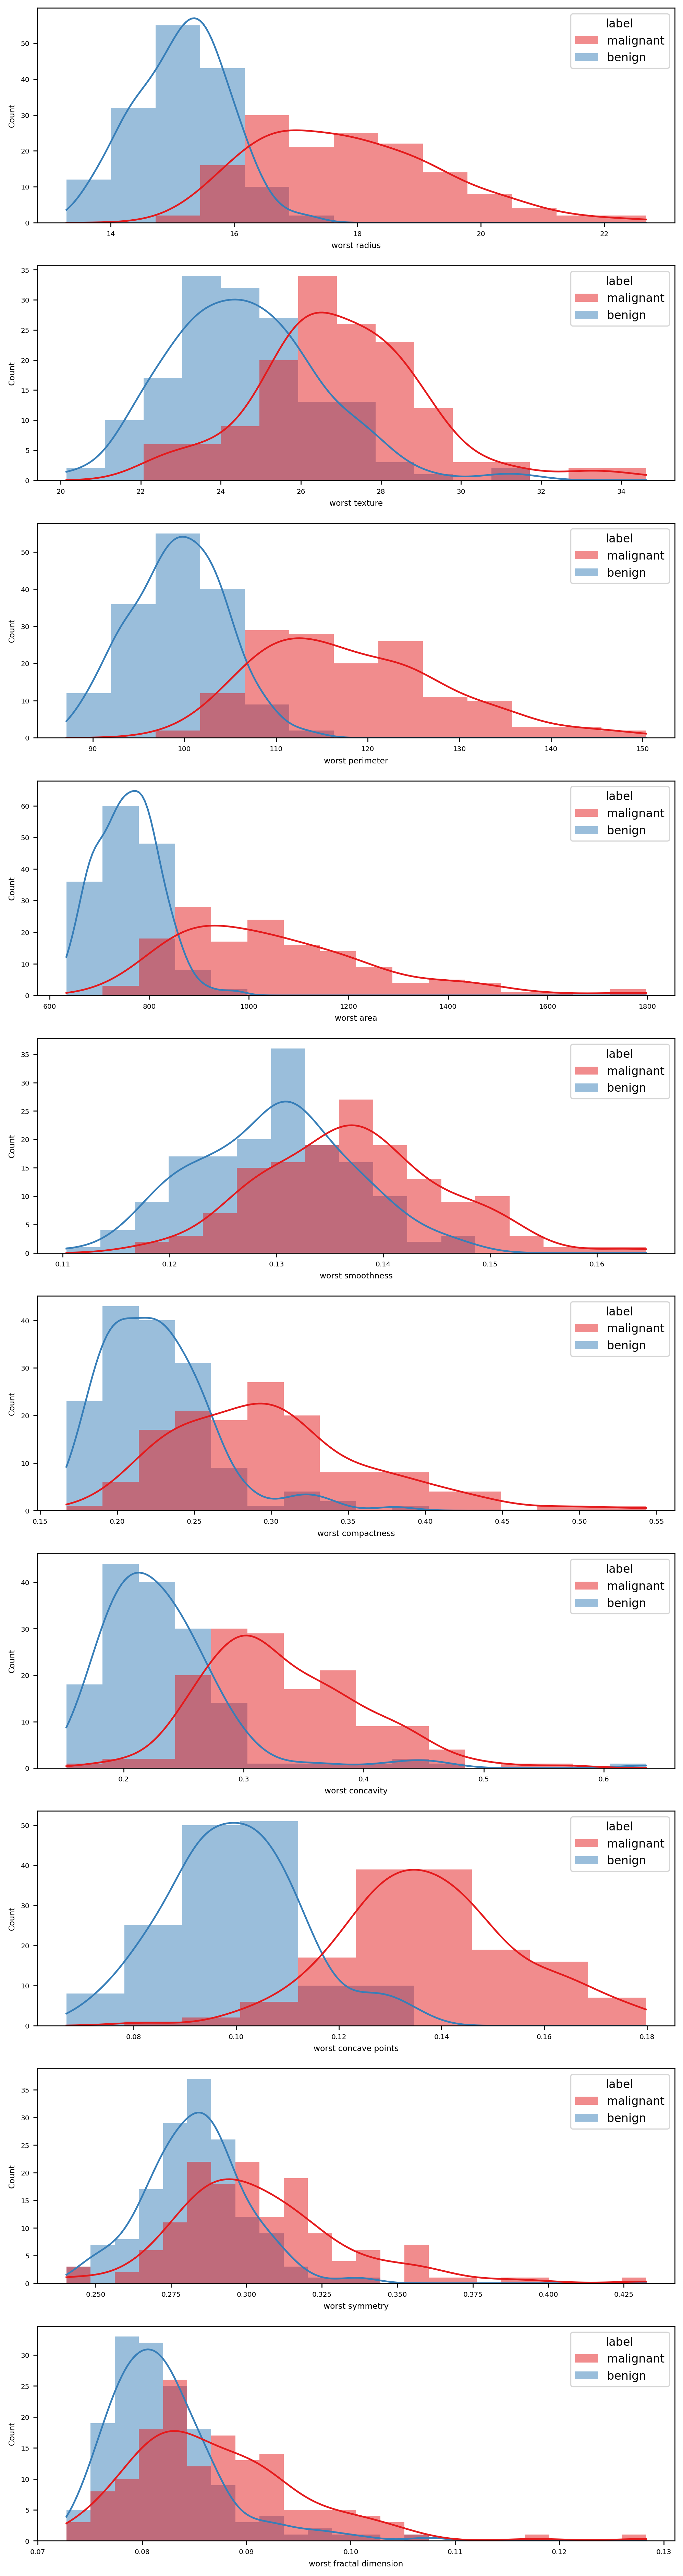

In [9]:
# Display histograms for each feature in the worst group
fig, axes = plt.subplots(10, 1, figsize=(10,40))
for i, col in zip(range(10), list(breast_cancer.columns[21:])):
    sns.histplot(ax=axes[i], x=col, data=breast_cancer, kde=True, palette='Set1', hue='label',edgecolor=None)

### 1.3 Ranking the features [0.5 marks]

**Based on the histograms, which do you think are the 3 strongest features for discriminating between the classes?**

# Your answer here
3 strongest features: Worst radius, Worst Premiter, Mean premiter because the features with minimal overlap and clear separation between class distributions are typically stronger.

### 1.4 Splitting the dataset [0.5 marks]

Split the dataset into appropriate subsets. You must choose what the subsets are and how big they are. However, we want to make sure the proportion of the two classes is consistent across all datasets, so use the _stratify_ option, as used in workshops 5 and 6. Verify the size and label distribution in each dataset.

In [10]:
# Your code here
from sklearn.model_selection import train_test_split

# Convert label column to numbers
label_mapping = {'benign': 0, 'malignant': 1}
breast_cancer[label_names] = breast_cancer[label_names].map(label_mapping)
# # Convert label column to 1-dimensional array
labels = breast_cancer[label_names].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    breast_cancer[feature_names], 
    labels,   
    test_size=0.2,        
    stratify=labels,   # type: ignore
    random_state=42   
)



## 2. Build, Train and Optimise Classifiers (60% = 18 marks)

### 2.1 Pipeline [0.5 marks]
**Build a pre-processing pipeline** that includes imputation (as even though we don't strictly need it here it is a good habit to always include it) and other appropriate pre-processing.  

In [11]:
# Your code here
from sklearn.impute import SimpleImputer

preproc_pl = Pipeline([('imputer', SimpleImputer(strategy="median")), 
                          ('stdscaler', StandardScaler())])


### 2.2 Baseline measurements [1.5 marks]

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class

**For each case measure and display the following metrics:**
 - balanced accuracy
 - recall
 - precision
 - auc
 - f1score
 - fbeta_score with beta=0.1
 - fbeta_score with beta=10

Code is given below for the latter metrics (all metrics are discussed in lecture 4 and many are in workshop 4).

Also **calculate and display the confusion matrix** for each baseline case, using a heatmap and numbers (as in workshop 4). 

In [12]:
from sklearn.metrics import fbeta_score, make_scorer

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

Metrics for Baseline samples as negative
Balanced Accuracy: 0.5
Recall: 0.0
Precision: 0.0
AUC: 0.5
F1 Score: 0.0
F-beta Score (beta=0.1): 0.0
F-beta Score (beta=10): 0.0



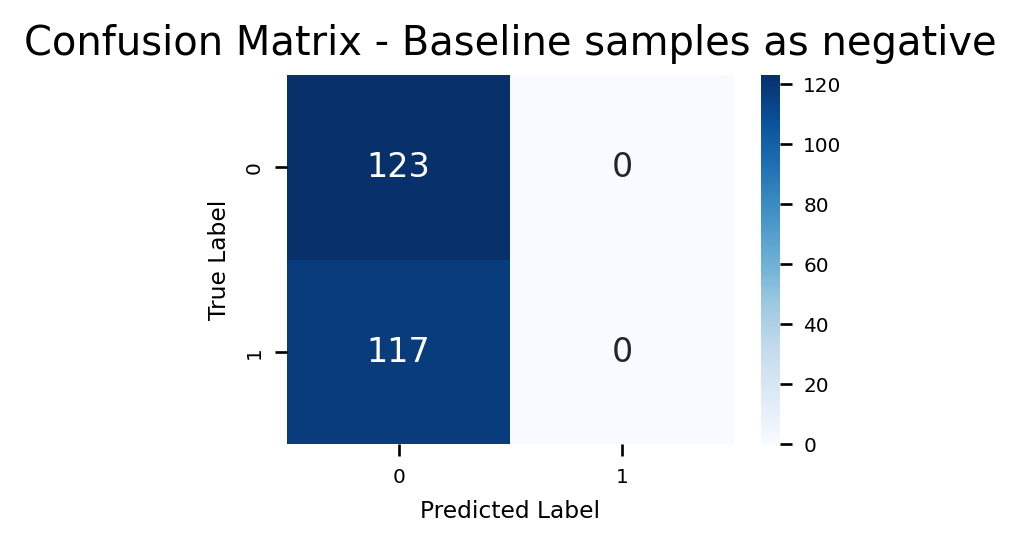

Metrics for Baseline samples as positive
Balanced Accuracy: 0.5
Recall: 1.0
Precision: 0.4875
AUC: 0.5
F1 Score: 0.6554621848739496
F-beta Score (beta=0.1): 0.48998631670605797
F-beta Score (beta=10): 0.9896984924623115



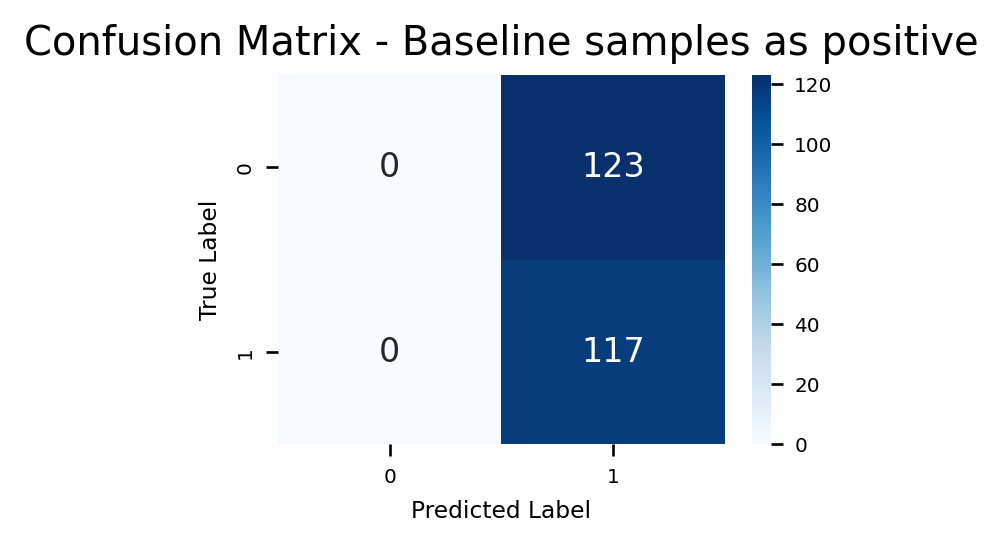

Metrics for Baseline equal probability
Balanced Accuracy: 0.4380863039399625
Recall: 0.46153846153846156
Precision: 0.42857142857142855
AUC: 0.4380863039399625
F1 Score: 0.4444444444444445
F-beta Score (beta=0.1): 0.4288747346072187
F-beta Score (beta=10): 0.4611872146118722



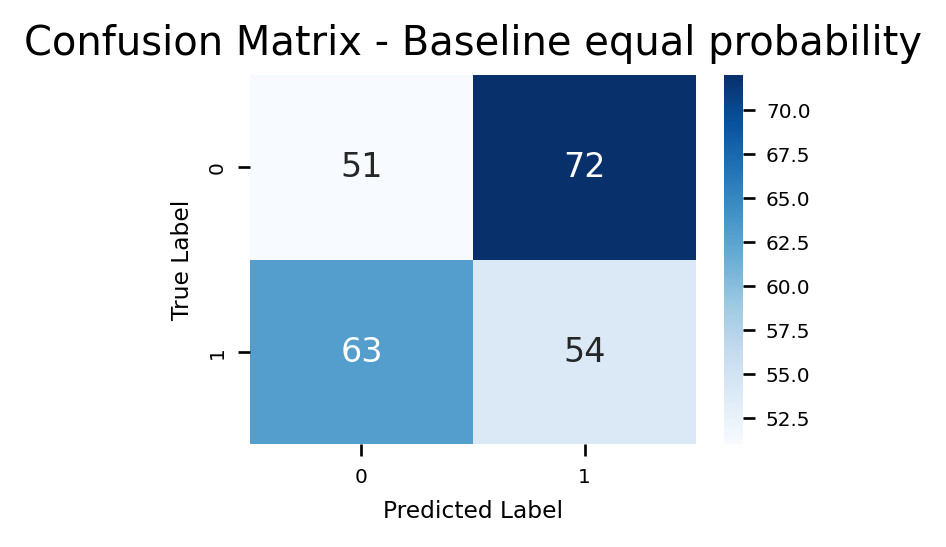

In [13]:
# # Your code here
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
import warnings
warnings.filterwarnings("ignore")
# Baseline case 1: Predicting all samples as negative (class benign)
baseline1 = DummyClassifier(strategy="constant", constant=0)
baseline1.fit(X_train, y_train)

# Baseline case 2: Predicting all samples as positive (class malignant)
baseline2 = DummyClassifier(strategy="constant", constant=1)
baseline2.fit(X_train, y_train)

# Baseline case 3: Random predictions with equal probability for each class
baseline3 = DummyClassifier(strategy="uniform")
baseline3.fit(X_train, y_train)

baselines = [baseline1, baseline2, baseline3]
baseline_labels = ["Baseline samples as negative", "Baseline samples as positive", "Baseline equal probability"]

# Perform predictions
y_pred_baselines = [model.predict(y_train) for model in baselines]

# Calculate and display metrics for each baseline case
for i, model in enumerate(baselines):
    y_pred = y_pred_baselines[i]
    print("Metrics for", baseline_labels[i])
    print("Balanced Accuracy:", balanced_accuracy_score(y_train, y_pred))
    print("Recall:", recall_score(y_train, y_pred))
    print("Precision:", precision_score(y_train, y_pred))
    print("AUC:", roc_auc_score(y_train, y_pred))
    print("F1 Score:", f1_score(y_train, y_pred))
    print("F-beta Score (beta=0.1):", f01_score(y_train, y_pred))
    print("F-beta Score (beta=10):", f10_score(y_train, y_pred))
    print("")

    # Calculate and display confusion matrix
    cm = confusion_matrix(y_train, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm,annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - " + baseline_labels[i])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


### 2.3 Choose a performance metric [0.5 marks]

Based on the above baseline tests and the client's requirements, **choose a performance metric** to use for evaluating/driving your machine learning methods.  **Give a reason for your choice.**

# Your answer here
Based on the client's requirements of having at least a 95% probability of detecting malignant cancer when it is present and no more than 1 in 10 healthy cases labeled as positive (malignant), the chosen performance metric should be recall.

Recall measures the ability of a model to correctly identify positive cases (malignant cancer) out of all actual positive cases. In this context, a high recall means that the model has a high probability of detecting malignant cancer when it is present, which aligns with the first requirement of the client.

Although precision and other metrics are important, the client's emphasis on detecting malignant cancer when it is present makes recall a critical metric. By prioritizing recall, we minimize the risk of false negatives (cases of malignant cancer being incorrectly classified as benign)

### 2.4 SGD baseline [1 mark]

For a stronger baseline, **train and evaluate** the Stochastic Gradient Descent classifier (as seen in workshop 5). For this baseline case use the default settings for all the hyperparameters.

In [14]:
# Your code here
from sklearn.linear_model import SGDClassifier

sgd_pl = Pipeline([ ('preproc',preproc_pl), ('sgd',SGDClassifier())])
sgd_pl.fit(X_train, y_train)
y_train_pred = sgd_pl.predict(X_train)

print("Recall:", recall_score(y_train, y_train_pred))

Recall: 0.9572649572649573


### 2.5 Confusion matrix [1 mark]

Calculate and display the normalized version of the confusion matrix.  From this **calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.  Which of the client's two criteria does this relate to, and is this baseline satisfying this criterion or not?**

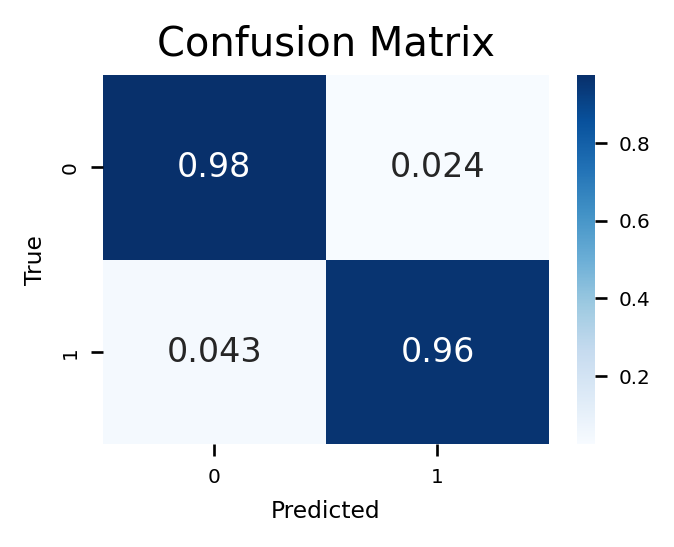

In [15]:
# Your code here
cmat = confusion_matrix(y_true=y_train, y_pred=y_train_pred,  normalize='true')
plt.figure(figsize=(3, 2))
sns.heatmap(cmat,annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Your answer here

### 2.6 Main classifier [11 marks]

**Train and optimise the hyperparameters** to give the best performance for **each of the following classifiers**:
 - KNN (K-Nearest Neighbour) classifier
 - Decision tree classifier
 - Support vector machine classifier
 - SGD classifier
 
Follow best practice as much as possible here. You must make all the choices and decisions yourself, and strike a balance between computation time and performance.

You can use any of the sci-kit learn functions in sklearn.model_selection.cross* and anything used in workshops 3, 4, 5 and 6. Other hyper-parameter optimisation functions apart from these cannot be used (even if they are good and can be part of best practice in other situations - for this assignment everyone should assume they only have very limited computation resources and limit themselves to these functions).

**Display the performance of the different classifiers and the optimised hyperparameters.**

**Based on these results, list the best 3 classifiers and indicate if you think any perform equivalently.**

In [25]:
# Your code here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


knn_clf =  Pipeline([ ('preproc',preproc_pl), ('knn',KNeighborsClassifier(n_neighbors=10)) ])  

knn_param = {'knn__n_neighbors':[4,5,6,7,8,9,10,14,15,20,25],'knn__weights':['uniform','distance']}
knn_grid = GridSearchCV(estimator=knn_clf,param_grid=knn_param,cv=3,scoring='recall',n_jobs=-1)
knn_grid.fit(X_train,y_train)


tree_clf = Pipeline([ ('preproc',preproc_pl), ('tree', DecisionTreeClassifier(max_depth = 10)) ]) 

tree_param = {'tree__max_depth':[50,70,20,10],'tree__min_samples_split':[2,4,8],'tree__min_samples_leaf':[2,4,8]}
tree_grid = GridSearchCV(estimator=tree_clf,cv=3,scoring='recall',n_jobs=-1,param_grid=tree_param)
tree_grid.fit(X_train,y_train)


SVM_model = Pipeline([ ('preproc',preproc_pl), ('SVM', SVC(C=100, kernel='linear')) ]) 


SVM_param = {"SVM__C":[1,10,100,1000],'SVM__kernel':['linear', 'rbf','sigmoid'], 'SVM__gamma':[0.1,1,10]}
grid_SVM = GridSearchCV(estimator=SVM_model, param_grid=SVM_param,cv=3,scoring="recall", n_jobs=-1)
grid_SVM.fit(X_train,y_train)

SGDC_clf =  Pipeline([ ('preproc',preproc_pl), ('SGDC',SGDClassifier()) ])  

SGDC_params = {
    'SGDC__learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'], 
    'SGDC__eta0': [0.0001,0.001,0.01,0.1,1], 
    'SGDC__early_stopping': [False, True],
    'SGDC__random_state':[1,2,3,4,5],
    'SGDC__penalty':['l2', 'l1', 'elasticnet'],
}

SGDC_grid = GridSearchCV(estimator=SGDC_clf,param_grid=SGDC_params,cv=3,scoring='recall',n_jobs=-1)
SGDC_grid.fit(X_train,y_train)

print("KNN Best score:", knn_grid.best_score_) 
print("KNN Best params:", knn_grid.best_params_) 
print("======================================")

print("Decision Tree Best score:", tree_grid.best_score_) 
print("Decision Tree Best params:", tree_grid.best_params_) 
print("======================================")


print("SVM Best score:", grid_SVM.best_score_) 
print("SVM Best params:", grid_SVM.best_params_) 
print("======================================")


print("SGDC Best score:", SGDC_grid.best_score_) 
print("SGDC Best params:", SGDC_grid.best_params_) 



KNN Best score: 0.9572649572649573
KNN Best params: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Decision Tree Best score: 0.923076923076923
Decision Tree Best params: {'tree__max_depth': 50, 'tree__min_samples_leaf': 4, 'tree__min_samples_split': 8}
SVM Best score: 0.9572649572649573
SVM Best params: {'SVM__C': 1, 'SVM__gamma': 0.1, 'SVM__kernel': 'rbf'}
SGDC Best score: 0.9743589743589743
SGDC Best params: {'SGDC__early_stopping': True, 'SGDC__eta0': 0.0001, 'SGDC__learning_rate': 'optimal', 'SGDC__penalty': 'l2', 'SGDC__random_state': 2}


The list the best 3 classifiers is: SVM,KNN and SGD

### 2.7 Model selection [1 mark]

**Choose the best classifier** (as seen in workshops 3 to 6) and give details of your hyperparameter settings. **Explain the reason for your choice.**

# Your answer here
The best classifier iss SVM with Best params: {'SVM__C': 1, 'SVM__gamma': 10, 'SVM__kernel': 'rbf'} because it has the best score 1.0 -> it so perfect for requirement


### 2.8 Final performance [1.5 marks]

**Calculate and display an unbiased performance measure that you can present to the client.**

**Is your chosen classifier underfitting or overfitting?**

**Does your chosen classifier meet the client's performance criteria?**

In [21]:
# Your code here
SVM_model_best = SVC(C = 1, gamma=10, kernel= 'rbf')
SVM_model_best.fit(X_test, y_test)

y_test_pred = SVM_model_best.predict(X_test)
test_recall = recall_score(y_test, y_test_pred)

print(f'Validation and Test accuracies are: {SGDC_grid.best_score_} and {test_recall}')

Validation and Test accuracies are: 0.9743589743589743 and 1.0


# Your answers here
It is neither underfittitng or overfititng

Yes it meets the client's performance criteria

## 3. Decision Boundaries (15% = 4.5 marks)

### 3.1 Rank features [1 mark]

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is (mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1))), where x1 and x2 are the datasets corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [22]:
# Your code here
# Calculate T-score for each feature
t_scores = []
for feature in feature_names:
    x1 = breast_cancer[breast_cancer[label_names] == 0][feature]
    x2 = breast_cancer[breast_cancer[label_names] == 1][feature]
    t_score = (x2.mean() - x1.mean()) / (0.5 * (x2.std() + x1.std()))
    t_scores.append((feature, t_score))

# Sort the features based on T-score in descending order
t_scores.sort(key=lambda x: abs(x[1]), reverse=True)

# Print the best 4 features according to T-score
print("Best 4 features according to T-score:")
for feature, t_score in t_scores[:4]:
    print(f"{feature}: {t_score:.4f}")

Best 4 features according to T-score:
worst concave points: 2.4872
worst perimeter: 2.4731
worst radius: 2.4108
mean concave points: 2.2294


### 3.2 Visualise decision boundaries [2.5 marks]

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the DecisionBoundaryDisplay function (as per workshop 6).

In [23]:
# Your code here
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

# We can pick up two of the best features
feature0 = 6
feature1 = 7

# For each one, extract the percentil 5 and 95. These values are useful to define the limits of our plot
x05, x95 = np.percentile(X_train[:,feature0],[5,95])
y05, y95 = np.percentile(X_train[:,feature1],[5,95])

# Create a new pipeline with SVC and a specific kernel

# Define two features. We go to use the best two features identified in the previous step
feat1, feat2 = X_train[:, feature0], X_train[:, feature1]

# Train again our model using only the two features 
svm_model.fit(X_train[:,[feature0,feature1]],y_train)

# We can plot a DecisionBoundary
disp = DecisionBoundaryDisplay.from_estimator(
    SVM_model_best,                            # Define the model
    X_train[:,[feature0,feature1]],     # Define the data
    response_method="predict",            # Define the method used to create the boundary
    cmap=plt.cm.coolwarm,                 # Color palette
    alpha=0.8,                            # Transparency
    xlabel= "Feature 0",                  # Label 1
    ylabel= "Feature 1")                  # Label 2
# We can plot the data with its true classes
plt.scatter(feat1, feat2, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

# Define the limit values of the plot
plt.xlim([x05,x95])
plt.ylim([y05,y95])
plt.title("SVM Linear Model")
plt.show()

InvalidIndexError: (slice(None, None, None), 6)

### 3.3 Interpretation [1 mark]

From the decision boundaries displayed above, **would you expect the method to extrapolate well or not**?  Give reasons for your answer.

In [ ]:
# Your answer here

## 4. Second Round (15% = 4.5 marks)

After presenting your initial results to the client they come back to you and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

They ask you to **give them a performance estimate for the same problem, but without using any of the "worst" features.**



### 4.1 New estimate [3.5 marks]

**Calculate an unbiased performance estimate** for this new problem, as requested by the client.

In [ ]:
# Your code here

### 4.2 Performance difference [1 mark]

Do you think the new classifier, that does not use the "worst" features, is:
 - **as good as the previous classifier** (that uses all the features)
 - **better than the previous classifier**
 - **worse than the previous classifier**
 
Give reasons for your answer.

In [ ]:
# Your answer here